In [1]:
import os
os.chdir('/home/jovyan/wav2betterlip')
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.nn import functional as F

from skimage import io as skimageio
import torchvision.transforms as image_transforms

from tqdm.auto import tqdm
from utils.spath import *
from utils.sdraw import *
from utils.smath import *
from utils.basel import Basel

import pandas as pd
import wandb
from sklearn.utils import shuffle
import functools
import random
from PIL import Image

from wav2lip.models.conv import Conv2dTranspose, Conv2d, nonorm_Conv2d
from wav2lip import audio

In [2]:
device = "cuda:2"
basel = Basel(device=device)
basel_cpu = Basel(device="cpu")

In [3]:
df = pd.read_parquet('workspace/updated_data.pq')

In [4]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
args = AttrDict()

###! environiment data
args.path="workspace"
args.device = "cuda:2"
args.num_workers = 4
args.batch_size=50
args.prefetch=1
args.name = "original"
args.pin_memory = True


###!data settings
#mel
args.syncnet_T = 5
args.syncnet_mel_step_size = 16
args.expression_orientation_size = 20

args.data_size=-1
args.shuffle = True
args.train_epoch_steps = 400000
args.test_epoch_steps = 10000

#training setting
args.optimizer = "adam"
args.generator_init_learning_rate = 1e-4
args.discriminator_init_learning_rate = 1e-4

args.generator_min_learning_rate = 4e-5
args.discriminator_min_learning_rate = 4e-5

args.decay_rate = 0.99

args.epochs = 100
args.start_syncloss_after = 300000

args.syncnet_weight = 0.03
args.disc_weight = 0.07

args.train_log_image = 400
args.test_log_image = 400

args.show_image_new_epoch = True

#images
args.model_mode = "original"
args.recombined_idx=48
args.cutout_face = True
args.cutout_margin = 5
args.syncnet_margin = 20 #because mouth is often in the middle of the screen

args.expression_match_idx = 0

args.model_path = "checkpoints/training-wav2betterlip"
args.pretrained_generator = ""#"wav2lip.pth"
args.pretrained_discriminator = ""

args.pretrained_lip_sync = "lip_sync.pth"

args.model_name = "wav2betterlip"
args.warmup_epochs = -1
args.use_wandb = True

args.original_resolution = [160,160]
args.resolution = [96,96]
args.label_smoothing = 0.05


###! audio settings

args.num_mels = 80  # Number of mel-spectrogram channels and local conditioning dimensionality
#  network
args.rescale = True  # Whether to rescale audio prior to preprocessing
args.rescaling_max = 0.9  # Rescaling value

# Use LWS (https://github.com/Jonathan-LeRoux/lws) for STFT and phase reconstruction
# It"s preferred to set True to use with https://github.com/r9y9/wavenet_vocoder
# Does not work if n_ffit is not multiple of hop_size!!
args.use_lws = False

args.n_fft = 800  # Extra window size is filled with 0 paddings to match this parameter
args.hop_size = 200  # For 16000Hz, 200 = 12.5 ms (0.0125 * sample_rate)
args.win_size = 800  # For 16000Hz, 800 = 50 ms (If None, win_size = n_fft) (0.05 * sample_rate)
args.sample_rate = 16000  # 16000Hz (corresponding to librispeech) (sox --i <filename>)

args.frame_shift_ms = None  # Can replace hop_size parameter. (Recommended: 12.5)

# Mel and Linear spectrograms normalization/scaling and clipping
args.signal_normalization = True
# Whether to normalize mel spectrograms to some predefined range (following below parameters)
args.allow_clipping_in_normalization = True  # Only relevant if mel_normalization = True
args.symmetric_mels = True
# Whether to scale the data to be symmetric around 0. (Also multiplies the output range by 2, 
# faster and cleaner convergence)
args.max_abs_value = 4.
# max absolute value of data. If symmetric, data will be [-max, max] else [0, max] (Must not 
# be too big to avoid gradient explosion, 
# not too small for fast convergence)
# Contribution by @begeekmyfriend
# Spectrogram Pre-Emphasis (Lfilter: Reduce spectrogram noise and helps model certitude 
# levels. Also allows for better G&L phase reconstruction)
args.preemphasize = True  # whether to apply filter
args.preemphasis = 0.97  # filter coefficient.

# Limits
args.min_level_db = -100
args.ref_level_db = 20
args.fmin = 55
# Set this to 55 if your speaker is male! if female, 95 should help taking off noise. (To 
# test depending on dataset. Pitch info: male~[65, 260], female~[100, 525])
args.fmax = 7600  # To be increased/reduced depending on data.

In [5]:
def match_expression(source_expression,stacked_expression,device,multipliers=(1,10),metric="L2",displacement = 1,print_loss=False):
    if type(source_expression)==list: 
        source_expression = torch.stack(source_expression)
    if type(stacked_expression)==list: 
        stacked_expression = torch.stack(stacked_expression)
        
    if "cpu" in device: 
        source_dlib = basel_cpu.get_expression(source_expression,2)
        stacked_dlib = basel_cpu.get_expression(stacked_expression,2)
    else:
        source_dlib = basel.get_expression(source_expression,2)
        stacked_dlib = basel.get_expression(stacked_expression,2)
    
    if len(source_dlib.shape)==2:
        source_dlib = source_dlib[None,None,:,:] 
    elif len(source_dlib.shape)==3:
        source_dlib = source_dlib[:,None,:,:] 
    
    stacked_dlib = stacked_dlib[None,:,:,:]
    
    
    
    mouth_idxs_norm = list(range(48, 68))
    mouth_stacked = stacked_dlib[:,:,mouth_idxs_norm,:]
    mouth_source = source_dlib[:,:,mouth_idxs_norm,:]
    
    
    if displacement>0:
        idxs = list(range(68))
        idxs.append(idxs.pop(0))

        mouth_idxs_shifted = list(mouth_idxs_norm)
        for disp in range(displacement):
            mouth_idxs_shifted.append(mouth_idxs_shifted.pop(0))

        mouth_stacked = stacked_dlib[:,:,mouth_idxs_norm,:] - stacked_dlib[:,:,mouth_idxs_shifted,:]
        mouth_source = source_dlib[:,:,mouth_idxs_norm,:] - source_dlib[:,:,mouth_idxs_shifted,:]

        stacked_dlib = stacked_dlib - stacked_dlib[:,:,idxs,:]
        source_dlib = source_dlib - source_dlib[:,:,idxs,:]
            
    
    if metric.upper()=="L1":
        face_loss = multipliers[0]*torch.abs(stacked_dlib - source_dlib).sum(dim=[2,3])
        mouth_loss =  multipliers[1]* (mouth_stacked - mouth_source).sum(dim=[2,3])
        z = face_loss + mouth_loss
    if metric.upper()=="L2":
        face_loss = multipliers[0]*torch.abs(stacked_dlib  - source_dlib).square().sum(dim=[2,3])
        mouth_loss =  multipliers[1]* (mouth_stacked - mouth_source).square().sum(dim=[2,3])
        z = face_loss + mouth_loss
    
    if print_loss: print(f"face: {face_loss.max()} mouth_loss {mouth_loss.max()}")
    sorted, indices = torch.sort(z,dim=1)
    return indices[0].tolist()
    

In [6]:
import functools
import time

class AudioToExpressionDataset(Dataset):
    
    def __init__(self, args, device='cpu',df=None, subset_df=None, mode="train"):
        
        self.device=device
        self.df = df       
        self.subset_df = subset_df
        self.window = args.syncnet_T # the sequence length
        self.mode = mode
        
        self.expression_match_idx = args.expression_match_idx    
        self.expression_orientation_size = args.expression_orientation_size
        self.cutout_face = args.cutout_face
        self.cutout_margin = args.cutout_margin
        self.syncnet_T = args.syncnet_T
        self.syncnet_mel_step_size = args.syncnet_mel_step_size
        self.recombined_idx=args.recombined_idx
        self.model_mode = args.model_mode
        self.args = args
        self.transform = image_transforms.Compose([
            image_transforms.Resize(args.resolution),
            image_transforms.ToTensor()
        ])

        
        
    def build_pandas(self,vid_path='workspace'):
        paths = []
        aligned_landmark_paths = [str(p) for p in glob(os.path.join(vid_path, '**/*.landmarks_aligned'), recursive=True)]
        aligned_landmark_paths.sort()
        data = []
        for lmrk in tqdm(aligned_landmark_paths):
            p = dirname(lmrk)
            extensions = ['deepspeech',"landmarks",'landmarks_aligned',"shape","expression","jpeg"]
            tmp = {"directory":str(relpath(p,vid_path))}
            for extension in extensions:
                extension_path = p/(str(Path(lmrk).stem).zfill(5) + "." + extension)
                if not os.path.exists(extension_path):
                    print(extension_path)
                    break
                tmp[extension] = extension_path
            else:
                data.append(tmp)
            
            paths.append(str(p/Path(lmrk).stem))
        return pd.DataFrame(data)
                       
    def __len__(self):
        return len(self.df if self.subset_df is None else self.subset_df)
    
#     @functools.lru_cache(maxsize=None)
    def load_full(self,path):
        return torch.load(path)
    
    @functools.lru_cache(maxsize=None)
    def load_deepspeech(self,idx):
        return torch.load(self.df.iloc[idx]["deepspeech"]).to(self.device)
    
    def load_expression(self,idx):
        return self.load_full(self.df.iloc[idx]["expression"])[self.df.iloc[idx]['offset']]
    
    def load_aligned_landmarks(self,idx):
        return self.load_full(self.df.iloc[idx]["landmarks_aligned"])[self.df.iloc[idx]['offset']]
    
    def load_shape(self,idx):
        return self.load_full(self.df.iloc[idx]["shape"])
    
#     @functools.lru_cache(maxsize=None)
    def load_landmarks(self,idx):
        return torch.load(self.df.iloc[idx]["landmarks"]).to(self.device)
    
#     @functools.lru_cache(maxsize=None)
    def load_face(self,idx):        
        return self.transform(Image.open(self.df.iloc[idx]["jpeg"]))
            
    def get_video_df(self,idx):
        return self.df.iloc[idx-self.df.iloc[idx]['offset']:idx-self.df.iloc[idx]['offset']+self.df.iloc[idx]['size']]
        
    def load_video_expressions(self,idx=None,subset_idx=None):
        if not subset_idx is None:
            idx = self.subset_to_full(subset_idx)
        video_df = self.get_video_df(idx)
        expressions = []
        for row_idx in video_df.index.tolist():
            expressions.append(self.load_expression(row_idx))
        return expressions, self.df.iloc[idx]['offset']
    
    def load_video_shapes(self,idx=None,subset_idx=None):
        if not subset_idx is None:
            idx = self.subset_to_full(subset_idx)
        video_df,row = self.get_video_df(idx)
        expressions = []
        for row_idx in video_df.index.tolist():
            expressions.append(self.load_shape(row_idx))
        return expressions, idx - video_df.index.tolist()[0]
    
    def plot_face(self,idx,mode="real"):
        if mode=="real":
            landmarks = self.load_landmarks(idx).cpu()
            img = self.load_face(idx)
            plot_faces([landmarks],[img],lines=FACE_LINES)
        if mode=="basel":
            expression = self.load_expression(idx)
            shape = self.load_shape(idx)
            dlib = basel_cpu.get_face(shape,expression).cpu()
            smart_plot(dlib,titles=["face"],lines=FACE_LINES)
        if mode=="aligned":
            dlib = self.load_aligned_landmarks(idx)
            smart_plot(dlib,titles=["face"],lines=FACE_LINES)

    def subset_to_full(self,subset_idx):
        return self.subset_df.loc[subset_idx]['index']
    
    def get_aligned_face(self,idx):
        offset =  df.iloc[idx]['offset']
        size = df.iloc[idx]['size']

        
        video_faces = [] 
        for i in range(idx-offset,idx-offset+size):
            video_faces.append(self.load_landmarks(i))
        
        norms = []
        
        for j,video_face in enumerate(video_faces):
            if j == offset:continue #same frame
            norms.append((np.linalg.norm(umeyama(video_faces[j][:48].numpy(),video_faces[offset][:48].numpy(),False)),j))

        norms.sort(key = lambda k:k[0])
        #returns the video indexes alligned for the target idx
        return [k[1] for k in norms]
    
    
    def get_image_window(self,idx):
        offset =  df.iloc[idx]['offset']
        size = df.iloc[idx]['size']
        data = {}
        
        #syncing issue?
        if offset+self.window>=size:
            idx = idx-offset + size - self.window
            offset =  df.iloc[idx]['offset']
                
        data['target_faces'] = []
        
        data['expression_priors'] = []
        data['expression_idxs'] = []
        
        data['pose_idxs'] = []
        
        data['recombined_faces'] = []
        data['idxs'] = []
        
        for i in range(idx,idx+self.window):
            data['target_faces'].append(self.load_face(i))
            data['idxs'].append(i)

            #pose prior
            if self.mode == "train":
                #if we are training, we use a random face as pose prior
                data['pose_idxs'].append(random.randrange(idx-offset,idx-offset+size))
                pose_prior = self.load_face(data['pose_idxs'][-1])
            else:
                #if we are not training, we use the target face as pose prior
                pose_prior = data['target_faces'][-1]
                data['pose_idxs'].append(i)
            
            if self.model_mode == "original":
                recombined = data['target_faces'][-1].clone()
                recombined[:,self.recombined_idx:,:] = 0
                
                #concatenate in channel dimension
                recombined_face = torch.cat((pose_prior,recombined),dim=0)

                data['recombined_faces'].append(recombined_face)
            
            else: 
                #expression prior
                if self.mode == "train":
                    #loads the full matrix
                    expressions = self.load_full(df.iloc[idx]['expression']).clone() #use clone, otherwise it messes with the lru cache
                    target_expression = expressions[offset]

                    alignments = self.get_aligned_face(i)[max(-self.expression_orientation_size,-len(expressions)+1):]
                    #find the best alligned faces
                    expressions = expressions[alignments]
                    matches = match_expression(self.load_expression(i),expressions,device="cpu")

                    data['expression_idxs'].append(alignments[matches[self.expression_match_idx]] + idx - offset)
                    data['expression_priors'].append(self.load_face(data['expression_idxs'][-1]))
                    

                else:
                    expressions = self.load_full(df.iloc[idx]['expression']).clone() #use clone, otherwise it messes with the lru cache
                    target_expression = expressions[offset]
                    
                    alignments = self.get_aligned_face(i)
                    #find the best alligned faces
                    expressions = expressions[alignments[:min(self.expression_orientation_size,len(expressions)-1)]]
                    matches = match_expression(self.load_expression(i),expressions,device="cpu")
                    
                    data['expression_idxs'].append(alignments[matches[self.expression_match_idx]] + idx - offset)
                    data['expression_priors'].append(self.load_face(data['expression_idxs'][-1]))
                    
                if self.cutout_face:
                    lmrk =  self.load_landmarks(data['expression_idxs'][-1])[48:,:2]
                    lmrk_max_min = [lmrk.min(dim=0)[0].tolist(),lmrk.max(dim=0)[0].tolist()]
                    
                    multiplier = [args.resolution[0]/args.original_resolution[0],args.resolution[1]/args.original_resolution[1]]
                    
                    lmrk_max_min[0] = [max(0,z-self.cutout_margin)*mult for mult,z in zip(multiplier,lmrk_max_min[0])]
                    lmrk_max_min[1] = [min(160,z+self.cutout_margin)*mult for mult,z in zip(multiplier,lmrk_max_min[1])]
                    
                    
                        
                    face_box = [slice(int(lmrk_max_min[0][1]),int(lmrk_max_min[1][1])),slice(int(lmrk_max_min[0][0]),int(lmrk_max_min[1][0]))]
                    
                    expression_prior_temp = torch.zeros(data['expression_priors'][-1].shape,dtype=data['expression_priors'][-1].dtype)
                    expression_prior_temp[:,face_box[0], face_box[1]] = data['expression_priors'][-1][:,face_box[0], face_box[1]]
                    
                    
                    recombined_face = torch.cat([data['target_faces'][-1][:,:self.recombined_idx,:],expression_prior_temp[:,self.recombined_idx:,:]],dim=1)
                else:
                    recombined_face = torch.cat([data['target_faces'][-1][:,:self.recombined_idx,:],data['expression_priors'][-1][:,self.recombined_idx:,:]],dim=1)
                
                #concatenate in channel dimension
                recombined_face = torch.cat((recombined_face,pose_prior),dim=0)
                data['recombined_faces'].append(recombined_face)

        
        data = {key:(torch.stack(val) if not "idxs" in key else val) for key,val in data.items() if not val == []}
        
        return data
    
    def crop_audio_window(self, spec, start_frame):
        start_frame_num = start_frame
        start_idx = int(80. * (start_frame_num / float(25))) #fps
        end_idx = start_idx + self.syncnet_mel_step_size # 16 == 80/25*5 syncnet_t, really unclear from the paper

        return spec[start_idx : end_idx, :]
    
    def get_segmented_mels(self, spec, start_frame):
        mels = []
        start_frame = offset = self.df.iloc[start_frame]['offset']
        size = self.df.iloc[start_frame]['size']
        
        for i in range(offset, offset + args.syncnet_T):
            m = self.crop_audio_window(spec, i-args.syncnet_T//2)
            if m.shape[0] != args.syncnet_mel_step_size:
                #at the end of the video
                print("start_frame",start_frame)
                print("mismel",m.shape)
                return None
            mels.append(m.T)
        mels = np.asarray(mels)

        return mels
    
    def get_audio_window(self,idx):
        wav = audio.load_wav(os.path.join(args.path,self.df.iloc[idx]['directory'],"audio.wav"), args.sample_rate)
        
        orig_mel = audio.melspectrogram(wav,args).T
        mel = self.crop_audio_window(orig_mel.copy(), df.iloc[idx]['offset'])
        mel = torch.FloatTensor(mel.T).unsqueeze(0)
        
        indiv_mels = self.get_segmented_mels(orig_mel.copy(), idx)
        indiv_mels = torch.FloatTensor(indiv_mels).unsqueeze(1)
        
        data = {}
        data['mel'] = mel
        data['individual_mels'] = indiv_mels
        return data
        
    def __getitem__(self, idx,subset=True):
        if subset:
            idx = self.subset_to_full(idx)
        
        offset = self.df.iloc[idx]['offset']
        size = self.df.iloc[idx]['size']
        
        if offset - args.syncnet_T//2 < 0: idx+=args.syncnet_T//2
        #we need 2*syncnet, to ensure the mels fit
        if offset + self.args.syncnet_T*1.5 > size: idx = idx - offset + size - int(self.args.syncnet_T*1.5)
         
        
        data = self.get_image_window(idx)
        data = {**data,**self.get_audio_window(idx)}

        return data
            
        
        
        
        
        
        

A2ED = AudioToExpressionDataset(args,df=df,subset_df=df[1:].reset_index(),mode="eval")


#A2ED.df= df = A2ED.build_pandas()

# df.drop(columns=['Unnamed: 0'],inplace=True)
# df.drop(columns=['Unnamed: 0.1'],inplace=True)

# df.to_csv("workspace/data.csv",index=False)


[37, 38, 39, 40, 41]
[37, 38, 39, 40, 41]
torch.Size([1, 80, 16])


Text(0.5, 1.0, 'target')

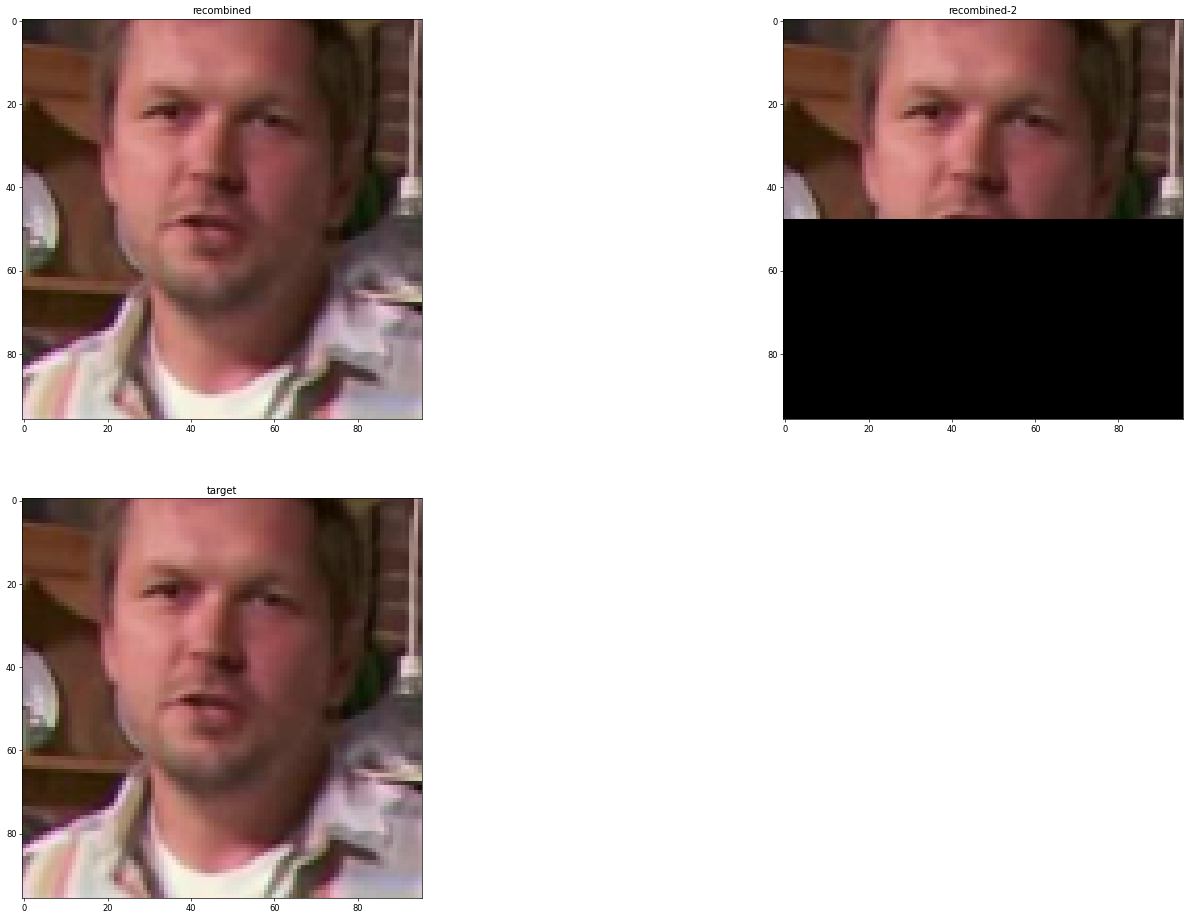

In [7]:
item = A2ED.__getitem__(34)
idx = 4
fig = plt.figure(figsize=(30, 30), dpi=60, )
# print(item['expression_idxs'])
print(item['idxs'])
print(item['pose_idxs'])
print(item['mel'].shape)


# ax = fig.add_subplot(3, 2, 1)
# ax.imshow(item['pose_priors'][idx].permute(1, 2, 0) )
# ax.set_title("pose_prior")

if A2ED.model_mode=="wav2betterlip":
    ax = fig.add_subplot(3,2, 2)
    ax.imshow(item['expression_priors'][idx].permute(1, 2, 0) )
    ax.set_title("expression_prior")

ax = fig.add_subplot(3, 2, 3)
ax.imshow(item['recombined_faces'][idx,:3].permute(1, 2, 0) )
ax.set_title("recombined")

ax = fig.add_subplot(3, 2, 4)
ax.imshow(item['recombined_faces'][idx,3:].permute(1, 2, 0) )
ax.set_title("recombined-2")


ax = fig.add_subplot(3, 2, 5)
ax.imshow(item['target_faces'][idx].permute(1, 2, 0) )
ax.set_title("target")






In [8]:
class Wav2Lip(nn.Module):
    def __init__(self):
        super(Wav2Lip, self).__init__()

        self.face_encoder_blocks = nn.ModuleList([
            nn.Sequential(Conv2d(6, 16, kernel_size=7, stride=1, padding=3)), # 96,96

            nn.Sequential(Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 48,48
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(32, 64, kernel_size=3, stride=2, padding=1),    # 24,24
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(64, 128, kernel_size=3, stride=2, padding=1),   # 12,12
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(128, 256, kernel_size=3, stride=2, padding=1),       # 6,6
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(256, 512, kernel_size=3, stride=2, padding=1),     # 3,3
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),),
            
            nn.Sequential(Conv2d(512, 512, kernel_size=3, stride=1, padding=0),     # 1, 1
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0)),])

        self.audio_encoder = nn.Sequential(
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(32, 64, kernel_size=3, stride=(3, 1), padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(64, 128, kernel_size=3, stride=3, padding=1),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(128, 256, kernel_size=3, stride=(3, 2), padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0),)

        self.face_decoder_blocks = nn.ModuleList([
            nn.Sequential(Conv2d(512, 512, kernel_size=1, stride=1, padding=0),),

            nn.Sequential(Conv2dTranspose(1024, 512, kernel_size=3, stride=1, padding=0), # 3,3
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),),

            nn.Sequential(Conv2dTranspose(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),), # 6, 6

            nn.Sequential(Conv2dTranspose(768, 384, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(384, 384, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(384, 384, kernel_size=3, stride=1, padding=1, residual=True),), # 12, 12

            nn.Sequential(Conv2dTranspose(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),), # 24, 24

            nn.Sequential(Conv2dTranspose(320, 128, kernel_size=3, stride=2, padding=1, output_padding=1), 
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),), # 48, 48

            nn.Sequential(Conv2dTranspose(160, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),),]) # 96,96

        self.output_block = nn.Sequential(Conv2d(80, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()) 

    def forward(self, audio_sequences, face_sequences):
        # audio_sequences = (B, T, 1, 80, 16)
        B = audio_sequences.size(0)
        
        face_sequences = face_sequences.permute(0,2,1,3,4) #[B,T,C,H,W] -> [B,C,T,H,W]

        input_dim_size = len(face_sequences.size())
        if input_dim_size > 4:
            audio_sequences = torch.cat([audio_sequences[:, i] for i in range(audio_sequences.size(1))], dim=0)
            face_sequences = torch.cat([face_sequences[:, :, i] for i in range(face_sequences.size(2))], dim=0)

        audio_embedding = self.audio_encoder(audio_sequences) # B, 512, 1, 1

        feats = []
        x = face_sequences
        for f in self.face_encoder_blocks:
            x = f(x)
            feats.append(x)

        x = audio_embedding
        for f in self.face_decoder_blocks:
            x = f(x)
            try:
                x = torch.cat((x, feats[-1]), dim=1)
            except Exception as e:
                print("error")
                print(x.size())
                print(feats[-1].size())
                raise e
            
            feats.pop()

        x = self.output_block(x)

        if input_dim_size > 4:
            x = torch.split(x, B, dim=0) # [(B, C, H, W)]
            outputs = torch.stack(x, dim=2) # (B, C, T, H, W)

        else:
            outputs = x
            
        return outputs #[B, C, T, H, W] 

class Wav2Lip_disc_qual(nn.Module):
    def __init__(self):
        super(Wav2Lip_disc_qual, self).__init__()

        self.face_encoder_blocks = nn.ModuleList([
            nn.Sequential(nonorm_Conv2d(3, 32, kernel_size=7, stride=1, padding=3)), # 48,96

            nn.Sequential(nonorm_Conv2d(32, 64, kernel_size=5, stride=(1, 2), padding=2), # 48,48
            nonorm_Conv2d(64, 64, kernel_size=5, stride=1, padding=2)),

            nn.Sequential(nonorm_Conv2d(64, 128, kernel_size=5, stride=2, padding=2),    # 24,24
            nonorm_Conv2d(128, 128, kernel_size=5, stride=1, padding=2)),

            nn.Sequential(nonorm_Conv2d(128, 256, kernel_size=5, stride=2, padding=2),   # 12,12
            nonorm_Conv2d(256, 256, kernel_size=5, stride=1, padding=2)),

            nn.Sequential(nonorm_Conv2d(256, 512, kernel_size=3, stride=2, padding=1),       # 6,6
            nonorm_Conv2d(512, 512, kernel_size=3, stride=1, padding=1)),

            nn.Sequential(nonorm_Conv2d(512, 512, kernel_size=3, stride=2, padding=1),     # 3,3
            nonorm_Conv2d(512, 512, kernel_size=3, stride=1, padding=1),),
            
            nn.Sequential(nonorm_Conv2d(512, 512, kernel_size=3, stride=1, padding=0),     # 1, 1
            nonorm_Conv2d(512, 512, kernel_size=1, stride=1, padding=0)),])

        self.binary_pred = nn.Sequential(nn.Conv2d(512, 1, kernel_size=1, stride=1, padding=0), nn.Sigmoid())
        self.label_noise = .0

    def get_lower_half(self, face_sequences):
        return face_sequences[:, :, face_sequences.size(2)//2:]

    def to_2d(self, face_sequences):
        B = face_sequences.size(0)
        face_sequences = torch.cat([face_sequences[:, :, i] for i in range(face_sequences.size(2))], dim=0)
        return face_sequences

    def perceptual_forward(self, false_face_sequences):
        false_face_sequences = self.to_2d(false_face_sequences)
        false_face_sequences = self.get_lower_half(false_face_sequences)

        false_feats = false_face_sequences
        for f in self.face_encoder_blocks:
            false_feats = f(false_feats)

        false_pred_loss = F.binary_cross_entropy(self.binary_pred(false_feats).view(len(false_feats), -1), 
                                        (torch.ones((len(false_feats), 1))).to(args.device))

        return false_pred_loss

    def forward(self, face_sequences):
        face_sequences = self.to_2d(face_sequences)
        face_sequences = self.get_lower_half(face_sequences)

        x = face_sequences
        for f in self.face_encoder_blocks:
            x = f(x)

        return self.binary_pred(x).view(len(x), -1)

# lip = build_model(args)['generator']
# lip.eval()
# with torch.no_grad():
#     A2ED.mode="train"
#     for x in torch.utils.data.DataLoader(A2ED,num_workers=0,batch_size=4,shuffle=False):
#         x = move_to(x,args.device)
#         output = lip(x['individual_mels'],x['recombined_faces'])
#         print(output.shape)
#         plt.imshow(output[0,:,0,:,:].permute(1,2,0).detach().cpu())
#         plt.show()

#         output = lip(x['individual_mels'],x['recombined_faces'])
#         plt.imshow(output[0,:,1,:,:].permute(1,2,0).detach().cpu())



#         break
# x=None

In [9]:
def get_sync_model(args):
    from wav2lip.models import SyncNet_color as SyncNet
    
    syncnet = SyncNet()
    syncnet.load_state_dict(torch.load(os.path.join(args.model_path,args.pretrained_lip_sync))['state_dict'])
    for p in syncnet.parameters():
        p.requires_grad = False
    return syncnet.to(args.device)

logloss = nn.BCELoss()
def cosine_loss(a, v, y):
    d = nn.functional.cosine_similarity(a, v)
    loss = logloss(d.unsqueeze(1), y)

    return loss

def get_sync_loss(model,g,mel,args):
    g = g[:, :, :, g.size(3)//2-args.syncnet_margin:-args.syncnet_margin]
    g = torch.cat([g[:, :, i] for i in range(args.syncnet_T)], dim=1)
    # B, 3 * T, H//2, W
    
    a, v = model(mel, g)
    y = torch.ones(g.size(0), 1).float().to(device)
    return cosine_loss(a, v, y)

In [10]:
import torch.optim as optim

def lr_decay(step, init_learning_rate = 1e-3, min_learning_rate = 1e-5, decay_rate = 0.9999):
    lr = ((init_learning_rate - min_learning_rate) *
          pow(decay_rate, step) +
          min_learning_rate)
    return lr

def build_model(args):
    wav2betterlip = Wav2Lip()
    discriminator = Wav2Lip_disc_qual()
    
    if not args.pretrained_generator == "":
        wav2betterlip.load_state_dict(torch.load(os.path.join(args.model_path,args.pretrained_generator))['state_dict'])
    if not args.pretrained_discriminator == "":
        discriminator.load_state_dict(torch.load(os.path.join(args.model_path,args.pretrained_discriminator))['state_dict'])
        
    return {'generator':wav2betterlip.to(args.device),
            'discriminator':discriminator.to(args.device),
            'syncnet':get_sync_model(args)
           }

build_model(args)

def get_optimizer(model,args):
    optimizer={}
    if args.optimizer=="adam":
        optimizer['generator']     = optim.Adam(model['generator'].parameters(), lr=args.generator_init_learning_rate)
        optimizer['discriminator'] = optim.Adam(model['discriminator'].parameters(), lr=args.discriminator_init_learning_rate)
        
    if args.optimizer=="ranger":
        optimizer = Ranger(model.parameters(), lr=args.init_learning_rate)
        
    scheduler = {
        'generator':torch.optim.lr_scheduler.LambdaLR(optimizer['generator'], lr_lambda=lambda step: lr_decay(step,args.generator_init_learning_rate,args.generator_min_learning_rate,args.decay_rate)/args.generator_init_learning_rate),
        'discriminator':torch.optim.lr_scheduler.LambdaLR(optimizer['discriminator'], lr_lambda=lambda step: lr_decay(step,args.discriminator_init_learning_rate,args.discriminator_min_learning_rate,args.decay_rate)/args.discriminator_min_learning_rate)
    }
    
    
    return optimizer,scheduler

for x in range(10):
    print(lr_decay(x,0.1,0.0001,0.9))


0.1
0.09001
0.08101900000000001
0.07292710000000001
0.06564439000000001
0.05908995100000001
0.05319095590000001
0.04788186031000001
0.04310367427900001
0.03880330685110001


In [11]:
class MultiEpochsDataLoader(torch.utils.data.DataLoader):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._DataLoader__initialized = False
        self.batch_sampler = _RepeatSampler(self.batch_sampler)
        self._DataLoader__initialized = True
        self.iterator = super().__iter__()

    def __len__(self):
        return len(self.batch_sampler.sampler)

    def __iter__(self):
        for i in range(len(self)):
            yield next(self.iterator)
    
    def __del__(self):
        del self.iterator

class _RepeatSampler(object):
    """ Sampler that repeats forever.
    Args:
        sampler (Sampler)
    """

    def __init__(self, sampler):
        self.sampler = sampler

    def __iter__(self):
        while True:
            yield from iter(self.sampler)

# df=pd.read_csv('workspace/data.csv')
def get_loaders(args):
    

    A2ED_train = AudioToExpressionDataset(df=df,subset_df=df[df['datasplit']=="train"][:args.data_size].reset_index(),mode="train",args=args)
    A2ED_test = AudioToExpressionDataset(df=df,subset_df=df[df['datasplit']=="test"][:args.data_size].reset_index(), mode="test",args=args)
    
    dataloader_params = {
        "batch_size":args.batch_size,
        "shuffle":args.shuffle, 
        "num_workers":args.num_workers,
        "pin_memory": args.pin_memory,
    }
    if args.num_workers>0:
        dataloader_params["prefetch_factor"]=args.prefetch

    trainloader = MultiEpochsDataLoader(A2ED_train,**dataloader_params)
    testloader = MultiEpochsDataLoader(A2ED_test,**dataloader_params)
    
    return {"test":testloader,
           "train":trainloader}

In [12]:
def move_to(obj, device):
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, dict):
        res = {}
        for k, v in obj.items():
            res[k] = move_to(v, device)
        return res
    elif isinstance(obj, list):
        res = []
        for v in obj:
            res.append(move_to(v, device))
        return res
    else:
        raise TypeError("Invalid type for move_to")

In [13]:
def step(generator,discriminator,syncnet,indiv_mels,mel,images,gt,args):
    generator_pred = generator(indiv_mels, images)
    
    
    
    if args.syncnet_weight > 0 and args.start_syncloss_after < args._step:
        sync_loss = args.syncnet_weight * get_sync_loss(syncnet, generator_pred, mel, args)
        sync_weight = args.syncnet_weight
    else:
        sync_loss = torch.tensor(0.)
        sync_weight = 0

    if args.disc_weight > 0.:
        perceptual_loss = discriminator.perceptual_forward(generator_pred)
    else:
        perceptual_loss = torch.tensor(0.)

    l1loss = F.l1_loss(generator_pred.permute(0,2,1,3,4), gt)

    generator_loss =  sync_loss*sync_weight + args.disc_weight  * perceptual_loss + \
                                (1. - sync_weight - args.disc_weight ) * l1loss
    
    pred = discriminator(gt.permute(0,2,1,3,4))
    disc_real_loss = F.binary_cross_entropy(pred, (torch.ones((len(pred), 1))-args.label_smoothing).to(args.device))

    pred = discriminator(generator_pred.detach())
    disc_fake_loss = F.binary_cross_entropy(pred, (torch.zeros((len(pred), 1))+args.label_smoothing).to(args.device))


    loss_dict = {"sync_loss":sync_loss*sync_weight,
                "perceptual_loss":perceptual_loss*args.disc_weight,
                "l1loss":l1loss*(1. - sync_weight - args.disc_weight ),
                "generator_loss":generator_loss,
                "disc_fake_loss":disc_fake_loss,
                "disc_real_loss":disc_real_loss
              }
    return loss_dict, generator_pred, 

In [14]:
def train(models,loader,optimizers,args):
    generator = models['generator']
    discriminator = models['discriminator']
    syncnet = models['syncnet']
    
    generator.train()
    discriminator.train()
    syncnet.eval()
    
    
    running_sync_loss, running_l1_loss, disc_loss, running_perceptual_loss = 0., 0., 0., 0.
    running_disc_real_loss, running_disc_fake_loss = 0., 0.
    
    steps = 0
    for i, data in enumerate(tqdm(loader)):
        if args.train_epoch_steps < steps:
            break
            
#         data = move_to(data, args.device)
        
        
        #make a single learning step
        loss_dict, generator_pred = step(generator,discriminator, syncnet, data['individual_mels'].to(args.device,non_blocking=True),data['mel'].to(args.device,non_blocking=True),data['recombined_faces'].to(args.device,non_blocking=True),data['target_faces'].to(args.device,non_blocking=True),args)
        
        optimizers['generator'].zero_grad()
        loss_dict['generator_loss'].backward()
        optimizers['generator'].step()
        
            
        optimizers['discriminator'].zero_grad()
        loss_dict['disc_fake_loss'].backward()
        loss_dict['disc_real_loss'].backward()
        optimizers['discriminator'].step()
        
        log_dict = {f"train_{key}":val.cpu().detach() for key,val in loss_dict.items()}
        
        if i%args.train_log_image == 0  or (i==0 and args.show_image_new_epoch):
            if args.use_wandb:
                log_dict['train_image'] = [wandb.Image(generator_pred[0,:,0,:,:].permute(1,2,0).detach().cpu().numpy(), caption=f"{args._step}")]
            else:
                plt.imshow(generator_pred[0,:,0,:,:].permute(1,2,0).detach().cpu())
                plt.title(f"train {args._step}")
                plt.show()        
        
        
        if args.use_wandb:
            wandb.log(log_dict,args._step)
        elif i%10==0:
            print(log_dict)
        
        args._step+=len(data['individual_mels'])
        steps += len(data['individual_mels'])
        del log_dict,generator_pred

        
        

In [15]:
def test(models,loader,args):
    generator = models['generator']
    discriminator = models['discriminator']
    syncnet = models['syncnet']
    
    generator.eval()
    discriminator.eval()
    syncnet.eval()
    
    steps = 0
    with torch.no_grad():
        running_generator_loss = 0
        running_sync_loss = 0
        
        for i, data in enumerate(tqdm(loader)):
            if args.test_epoch_steps < steps:
                break
        
#             data = move_to(data)
            
            loss_dict, generator_pred = step(generator,discriminator, syncnet, data['individual_mels'].to(args.device,non_blocking=True),data['mel'].to(args.device,non_blocking=True),data['recombined_faces'].to(args.device,non_blocking=True),data['target_faces'].to(args.device,non_blocking=True),args)
            log_dict = {f"eval_{key}":val.cpu() for key,val in loss_dict.items()}
            running_generator_loss+=loss_dict['generator_loss']
            running_sync_loss +=loss_dict['sync_loss']
            

            if i%args.test_log_image == 0 or (i==0 and args.show_image_new_epoch):  
                if args.use_wandb:
                    log_dict['test_image'] = [wandb.Image(generator_pred[0,:,0,:,:].permute(1,2,0).detach().cpu().numpy(), caption=f"{args._step}")]
                else:
                    plt.imshow(generator_pred[0,:,0,:,:].permute(1,2,0).detach().cpu())
                    plt.title(f"test {args._step}")
                    plt.show()
            
            if args.use_wandb:
                wandb.log(log_dict,args._step)
            elif i%10==0:
                print(log_dict)
            
            del loss_dict
            
            args._step+=len(data['individual_mels'])
            steps += len(data['individual_mels'])
            
        return running_generator_loss, running_sync_loss

In [16]:
def train_and_test(models,optimizer,loader_dict,scheduler,args):
    best_running_generator_loss = None
    best_running_sync_loss = None

    for i in range(args.epochs):
        train(models,loader_dict['train'],optimizer,args)
        running_generator_loss, running_sync_loss = test(models,loader_dict['test'],args)

        if i >= args.warmup_epochs:
            torch.save({"args":args,
                        'generator_state_dict': models['generator'].state_dict(),
                        'discriminator_state_dict': models['discriminator'].state_dict(),
                       }, 
                       os.path.join(args.model_path,f"{i}-{args.name}.pt")
                      )
            
            
def init_args(args):
    args._step = 0
    args._epoch=0
    
def run(args):
    init_args(args)
    
    models = build_model(args)
    optimizer,scheduler = get_optimizer(models,args)
    loader_dict = get_loaders(args)
    try:
        if args.use_wandb:
            wandb.init(project="deepfake",config=args,name=args.name)
            wandb.watch(models['generator'],log_freq=1)

        train_and_test(models,optimizer,loader_dict,scheduler,args)    
    except Exception as e:
        raise e
    finally:
        loader_dict['train'].__del__()
        loader_dict['test'].__del__()
        

In [ ]:
run(args)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: misterbuilder (use `wandb login --relogin` to force relogin)


  0%|          | 0/41773 [00:00<?, ?it/s]

In [ ]:
# loader = get_loaders(args)
# data = next(iter(loader['test']))
# model = get_model(args)


In [ ]:
def test_sync_loss(args):
    A2ED = AudioToExpressionDataset(args,df=df,subset_df=df,mode="eval")
    models = build_model(args)
    syncnet = get_sync_model(args)
    syncnet.eval()
    
    correct_cnt = 0
    length = 0
    for x in range(1100,4000,10):
        try:
            images = A2ED.get_image_window(x)
            audio = A2ED.get_audio_window(x)

            sync_loss_correct = get_sync_loss(syncnet, images['target_faces'].unsqueeze(0).permute(0,2,1,3,4).to(args.device), audio['mel'].unsqueeze(0).to(args.device), args)

            audio = A2ED.get_audio_window(x+3)
            sync_loss_incorrect = get_sync_loss(syncnet, images['target_faces'].unsqueeze(0).permute(0,2,1,3,4).to(args.device), audio['mel'].unsqueeze(0).to(args.device), args)
            print(f"correct: {sync_loss_correct} incorrect: {sync_loss_incorrect}, {sync_loss_correct<sync_loss_incorrect}")
            if sync_loss_correct<sync_loss_incorrect:
                correct_cnt+=1
            length+=1
        except:
            continue
    print(correct_cnt/length)
    
test_sync_loss(args)
    
    